## Load data

In [ ]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, LSTM, Bidirectional, BatchNormalization, Add
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report


In [ ]:
df_feats = pd.read_parquet("D:\Sleep Stages Classification\SleepStageClassifier\features\sleep-edf__telemetry_features_ALL__90s.parquet")
df_feats.shape

(42839, 366)

In [33]:
df_feats["label"].value_counts()

label
Sleep stage 2    19851
Sleep stage R     8349
Sleep stage W     4488
Sleep stage 1     3653
Sleep stage 3     3398
Sleep stage 4     3017
Movement time       83
Name: count, dtype: int64

In [34]:
df_feats[~df_feats.psg_file.isin(df_files.psg_file.unique())].psg_file.nunique()

0

In [35]:
df_feats.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 42839 entries, 1994-07-12 23:00:00 to 1994-09-16 07:44:00
Columns: 366 entries, EEG Fpz-Cz__TotalAbsPow__w=1m to patient_id
dtypes: float32(363), object(3)
memory usage: 60.6+ MB


In [36]:
eeg_signals = [d.name for d in data_processed if "EEG" in d.name]
bands = ["alpha", "beta", "sdelta", "fdelta", "sigma", "theta"]
for eeg_sig in eeg_signals:
    eeg_bands = [c for c in df_feats.columns if c.startswith(eeg_sig) and c.split("__")[1] in bands]
    windows = sorted(set(b.split("__")[-1] for b in eeg_bands))
    for window in windows:
        # Select the spectral powers
        delta = df_feats["__".join([eeg_sig, "sdelta", window])] + df_feats["__".join([eeg_sig, "fdelta", window])]
        fdelta_theta = df_feats["__".join([eeg_sig, "fdelta", window])] + df_feats["__".join([eeg_sig, "theta", window])]
        alpha = df_feats["__".join([eeg_sig, "alpha", window])]
        beta = df_feats["__".join([eeg_sig, "beta", window])]
        theta = df_feats["__".join([eeg_sig, "theta", window])]
        sigma = df_feats["__".join([eeg_sig, "sigma", window])]
        # Calculate the ratios
        df_feats["__".join([eeg_sig, "fdelta+theta", window])] = fdelta_theta.astype("float32")        

        df_feats["__".join([eeg_sig, "alpha/theta", window])] = (alpha / theta).astype("float32")
        df_feats["__".join([eeg_sig, "delta/beta", window])] = (delta / beta).astype("float32")
        df_feats["__".join([eeg_sig, "delta/sigma", window])] = (delta / sigma).astype("float32")
        df_feats["__".join([eeg_sig, "delta/theta", window])] = (delta / theta).astype("float32")
df_feats.shape

(42839, 396)

In [37]:
skip_cols = ["psg_file", "label", "patient_id"]
feat_cols = [c for c in df_feats.columns if c not in skip_cols]

In [38]:
# Add the 30s features from the minute before and the minute after the epoch (= current sample of 30s) to the epoch
feats_30s = [f for f in df_feats.columns if "w=30s" in f]
feats_60s = [f for f in df_feats.columns if "w=1m_" in f]
feats_90s = [f for f in df_feats.columns if "w=1m30s" in f]
print(len(feats_30s), len(feats_60s), len(feats_90s))
dfs = []
for psg_file in df_feats.psg_file.unique():
    sub_df = df_feats[df_feats.psg_file == psg_file]

    sub_df = sub_df.merge(
        sub_df[feats_90s].shift(1).add_suffix("_shift=30s"),
        left_index=True,
        right_index=True,
    )
    sub_df = sub_df.drop(columns=feats_90s)

    sub_df = sub_df.merge(
        sub_df[feats_60s].shift(1).add_suffix("_shift=30s"),
        left_index=True,
        right_index=True,
    )

    sub_df = sub_df.merge(sub_df[feats_30s].shift(2).add_suffix("_shift=1m"), left_index=True, right_index=True)
    sub_df = sub_df.merge(sub_df[feats_30s].shift(1).add_suffix("_shift=30s"), left_index=True, right_index=True)
    sub_df = sub_df.merge(sub_df[feats_30s].shift(-1).add_suffix("_shift=-30s"), left_index=True, right_index=True)
    sub_df = sub_df.merge(sub_df[feats_30s].shift(-2).add_suffix("_shift=-1m"), left_index=True, right_index=True)
    dfs += [sub_df]
df_feats = pd.concat(dfs)
df_feats.shape

131 0 131


(42839, 920)

In [39]:
df_feats.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 42839 entries, 1994-07-12 23:00:00 to 1994-09-16 07:44:00
Columns: 920 entries, EEG Fpz-Cz__TotalAbsPow__w=1m to EEG Pz-Oz__delta/theta__w=30s_shift=-1m
dtypes: float32(917), object(3)
memory usage: 151.2+ MB


In [40]:
# Postprocess labels
df_feats.loc[df_feats["label"] == "Sleep stage 4", "label"] = "Sleep stage 3"
df_feats = df_feats[df_feats["label"] != "Movement time"]
df_feats = df_feats[df_feats["label"] != "Sleep stage ?"]  # Label that is given when recording is done / end of the night

df_feats = df_feats[~df_feats["label"].isna()]

In [41]:
df_feats.shape

(42756, 920)

### Look into nan features

In [42]:
no_shift_cols = [c for c in df_feats.columns if not "shift=" in c]# or "w=1m" in c or "w=1m30s" in c]
len(no_shift_cols)

265

In [43]:
normal_nan_mask = (df_feats[no_shift_cols].isna().sum() / df_feats.psg_file.nunique()).isin([0, 1, 2])
df_feats[np.array(no_shift_cols)[~normal_nan_mask]].isna().sum().sort_values()[::-1]

EEG Pz-Oz__delta/theta__w=1m                             7
EEG Pz-Oz__TotalAbsPow__w=1m                             7
EEG Pz-Oz__beta__w=1m                                    7
EEG Pz-Oz__binned_entropy_{'max_bins': 10}__w=1m         7
EEG Pz-Oz__binned_entropy_{'max_bins': 30}__w=1m         7
                                                        ..
EOG horizontal__binned_entropy_{'max_bins': 10}__w=1m    7
EOG horizontal__binned_entropy_{'max_bins': 30}__w=1m    7
EOG horizontal__binned_entropy_{'max_bins': 5}__w=1m     7
EOG horizontal__binned_entropy_{'max_bins': 60}__w=1m    7
EEG Fpz-Cz__TotalAbsPow__w=1m                            7
Length: 131, dtype: int64

## EDA on labels

<Axes: xlabel='label'>

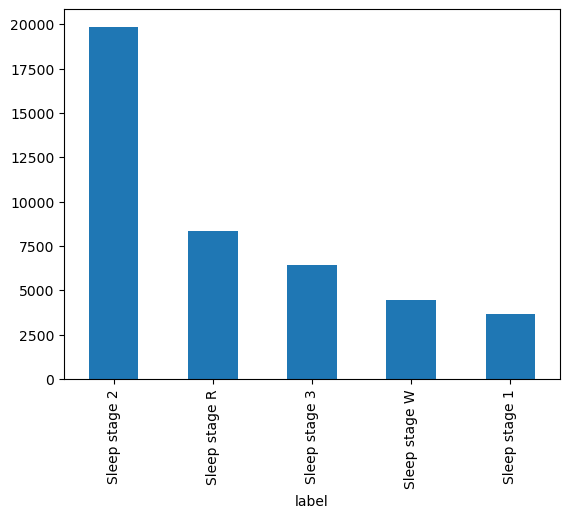

In [44]:
df_feats["label"].value_counts().plot(kind="bar")

In [45]:
df_feats["label"].value_counts()

label
Sleep stage 2    19851
Sleep stage R     8349
Sleep stage 3     6415
Sleep stage W     4488
Sleep stage 1     3653
Name: count, dtype: int64

=> There is quite some label imbalance

# Transformers

In [ ]:

@tf.keras.utils.register_keras_serializable()
class AttentionLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(AttentionLayer, self).__init__()

    def build(self, input_shape):
        self.attention_weights = self.add_weight(
            shape=(input_shape[-1], 1),
            initializer="random_normal",
            trainable=True
        )

    def call(self, inputs):
        scores = tf.nn.softmax(tf.matmul(inputs, self.attention_weights), axis=1)
        return tf.reduce_sum(inputs * scores, axis=1)

# Define Stacked LSTM + Attention Model with Residual Connections
def create_lstm_attention_model(input_shape, num_classes, dropout_rate=0.5, l2_reg=1e-4):
    input_layer = Input(shape=input_shape)

    # **First Bidirectional LSTM with Residual Connection**
    x = Bidirectional(LSTM(128, return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(l2_reg)))(input_layer)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)
    
    res_1 = x  # Residual Connection

    # **Second Bidirectional LSTM**
    x = Bidirectional(LSTM(128, return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(l2_reg)))(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)
    
    x = Add()([x, res_1])  # Residual Connection

    # **Attention Layer**
    x = AttentionLayer()(x)
    x = BatchNormalization()(x)  # Normalizing attention output

    # **Fully Connected Layers with Residual Connection**
    res_2 = x  # Residual Connection

    x = Dense(512, activation=tf.keras.activations.swish, kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)

    x = Dense(256, activation=tf.keras.activations.swish, kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)

    x = Dense(256, activation=tf.keras.activations.swish, kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(x)  # Fix: Match residual size
    x = Dropout(dropout_rate)(x)

    x = Add()([x, res_2])  # Residual Connection

    # **Classification Layer**
    output_layer = Dense(num_classes, activation="softmax")(x)

    return Model(inputs=input_layer, outputs=output_layer)

# Load EEG Features
feature_cols = [c for c in df_feats.columns if "shift=" not in c and c not in ["label", "psg_file", "patient_id"]]
X = df_feats[feature_cols].fillna(0)  # Fill NaNs if needed
y = df_feats["label"]

# Encode Labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model Parameters
input_shape = (X_train.shape[1], 1)  # Reshape for LSTM
num_classes = len(label_encoder.classes_)
dropout_rate = 0.5
l2_reg = 1e-4

# Reshape Input for LSTM
X_train = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.values.reshape((X_test.shape[0], X_test.shape[1], 1))

# Build and Compile Model
model = create_lstm_attention_model(input_shape, num_classes, dropout_rate, l2_reg)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),  # Slightly lower learning rate for stability
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# Model Summary
model.summary()

# Training
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,  # Increased to 50 epochs
    batch_size=16,  # Lower batch size for better generalization
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
        tf.keras.callbacks.ModelCheckpoint("best_lstm_attention_model.keras", save_best_only=True, monitor="val_loss"),
        tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6, verbose=1)  # Dynamic LR Adjustment
    ]
)

# Evaluate Model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")


14-Mar-25 17:02:26 | WARNING | From C:\Users\marie\AppData\Roaming\Python\Python311\site-packages\keras\src\backend\tensorflow\core.py:222: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 262, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 262, 256)  │    133,120 │ input_layer[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 262, 256)  │      1,024 │ bidirectional[0]… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 262, 256)  │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 262, 256)  │    394,240 │ dropout[0][0]     │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 262, 256)  │      1,024 │ bidirectional_1[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 262, 256)  │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 262, 256)  │          0 │ dropout_1[0][0],  │
│                     │                   │            │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer     │ (None, 256)       │        256 │ add[0][0]         │
│ (AttentionLayer)    │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ attention_layer[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 512)       │    131,584 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512)       │      2,048 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 512)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │    131,328 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_1[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 256)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 256)       │     65,792 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 256)       │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 256)       │          0 │ dropout_4[0][0],  │
│                     │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 863,749 (3.29 MB)

 Trainable params: 860,677 (3.28 MB)

 Non-trainable params: 3,072 (12.00 KB)

Epoch 1/50
2138/2138 ━━━━━━━━━━━━━━━━━━━━ 816s 379ms/step - accuracy: 0.5838 - loss: 1.4513 - val_accuracy: 0.7351 - val_loss: 0.9479 - learning_rate: 5.0000e-04
Epoch 2/50
2138/2138 ━━━━━━━━━━━━━━━━━━━━ 937s 438ms/step - accuracy: 0.7835 - loss: 0.7498 - val_accuracy: 0.7975 - val_loss: 0.6946 - learning_rate: 5.0000e-04
Epoch 3/50
2138/2138 ━━━━━━━━━━━━━━━━━━━━ 875s 409ms/step - accuracy: 0.8045 - loss: 0.6903 - val_accuracy: 0.8162 - val_loss: 0.6178 - learning_rate: 5.0000e-04
Epoch 4/50
2138/2138 ━━━━━━━━━━━━━━━━━━━━ 833s 389ms/step - accuracy: 0.8167 - loss: 0.6343 - val_accuracy: 0.7574 - val_loss: 0.7981 - learning_rate: 5.0000e-04
Epoch 5/50
2138/2138 ━━━━━━━━━━━━━━━━━━━━ 831s 389ms/step - accuracy: 0.8221 - loss: 0.5967 - val_accuracy: 0.8177 - val_loss: 0.5921 - learning_rate: 5.0000e-04
Epoch 6/50
2138/2138 ━━━━━━━━━━━━━━━━━━━━ 844s 395ms/step - accuracy: 0.8298 - loss: 0.5615 - val_accuracy: 0.8071 - val_loss: 0.6337 - learning_rate: 5.0000e-04
Epoch 7/50
2138/2138 ━━━━━━━

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


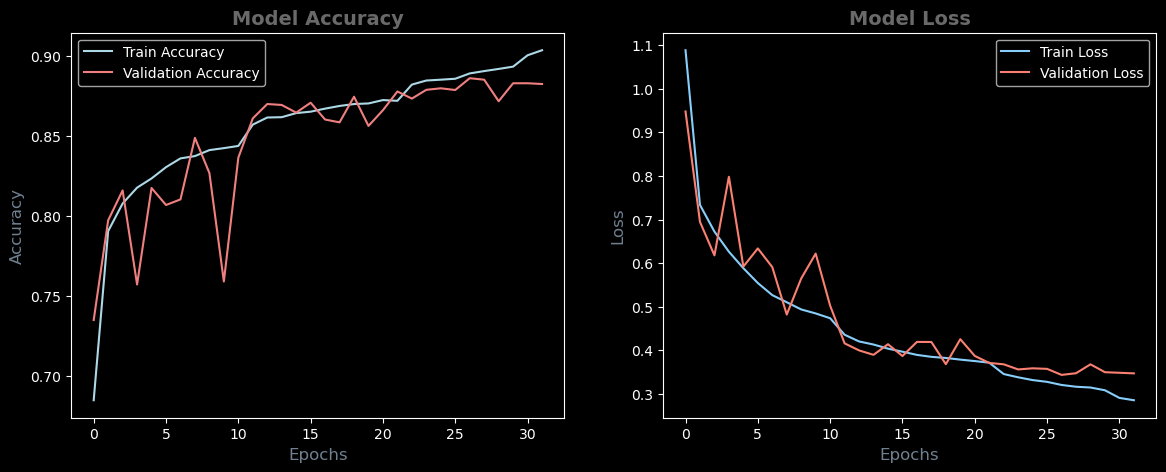

268/268 ━━━━━━━━━━━━━━━━━━━━ 58s 215ms/step


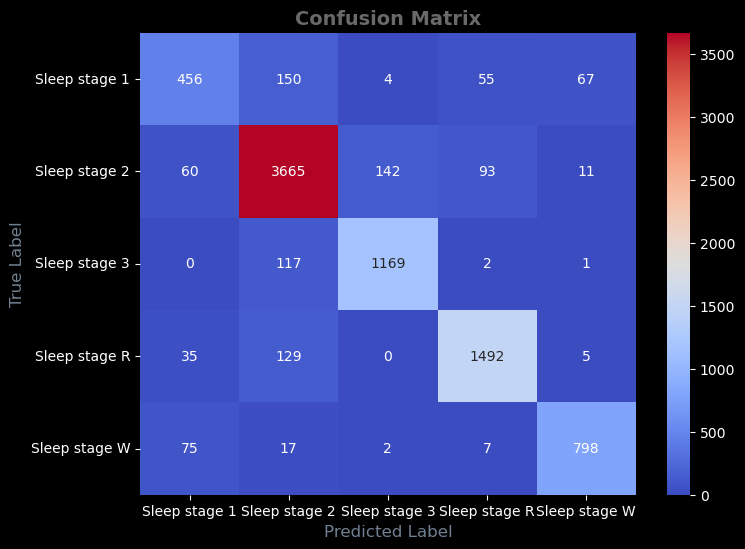

Classification Report:
                precision    recall  f1-score   support

Sleep stage 1       0.73      0.62      0.67       732
Sleep stage 2       0.90      0.92      0.91      3971
Sleep stage 3       0.89      0.91      0.90      1289
Sleep stage R       0.90      0.90      0.90      1661
Sleep stage W       0.90      0.89      0.90       899

     accuracy                           0.89      8552
    macro avg       0.86      0.85      0.86      8552
 weighted avg       0.88      0.89      0.88      8552



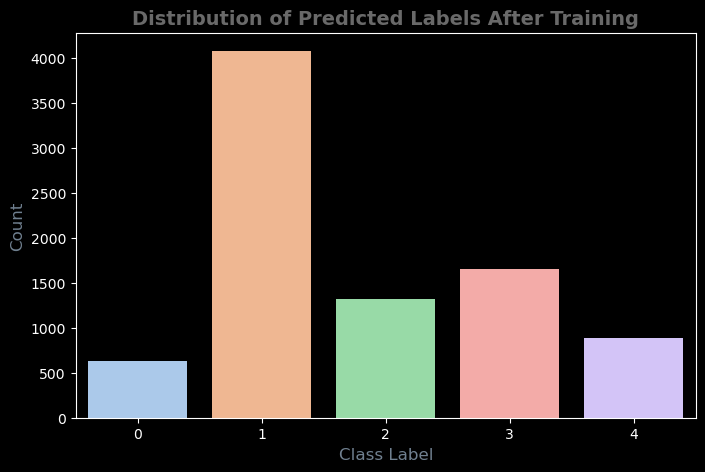

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf

# 1. Print model architecture as an image
tf.keras.utils.plot_model(model, to_file="model_architecture.png", show_shapes=True, show_layer_names=True)

# 2. Plot Accuracy and Loss Graphs
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy plot
axes[0].plot(history.history['accuracy'], label='Train Accuracy', color='lightblue')
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy', color='lightcoral')
axes[0].set_title('Model Accuracy', fontsize=14, fontweight='bold', color='dimgray')
axes[0].set_xlabel('Epochs', fontsize=12, color='slategray')
axes[0].set_ylabel('Accuracy', fontsize=12, color='slategray')
axes[0].legend()

# Loss plot
axes[1].plot(history.history['loss'], label='Train Loss', color='lightskyblue')
axes[1].plot(history.history['val_loss'], label='Validation Loss', color='salmon')
axes[1].set_title('Model Loss', fontsize=14, fontweight='bold', color='dimgray')
axes[1].set_xlabel('Epochs', fontsize=12, color='slategray')
axes[1].set_ylabel('Loss', fontsize=12, color='slategray')
axes[1].legend()

plt.show()

# 3. Print Confusion Matrix
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Label", fontsize=12, color='slategray')
plt.ylabel("True Label", fontsize=12, color='slategray')
plt.title("Confusion Matrix", fontsize=14, fontweight='bold', color='dimgray')
plt.show()

# 4. Print Classification Report
report = classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_)
print("Classification Report:\n", report)

# 5. Distribution of Labels After Training
label_counts = pd.Series(y_pred_classes).value_counts().sort_index()
plt.figure(figsize=(8, 5))
sns.barplot(x=label_counts.index, y=label_counts.values, palette="pastel")
plt.xlabel("Class Label", fontsize=12, color='slategray')
plt.ylabel("Count", fontsize=12, color='slategray')
plt.title("Distribution of Predicted Labels After Training", fontsize=14, fontweight='bold', color='dimgray')
plt.show()


268/268 ━━━━━━━━━━━━━━━━━━━━ 46s 172ms/step


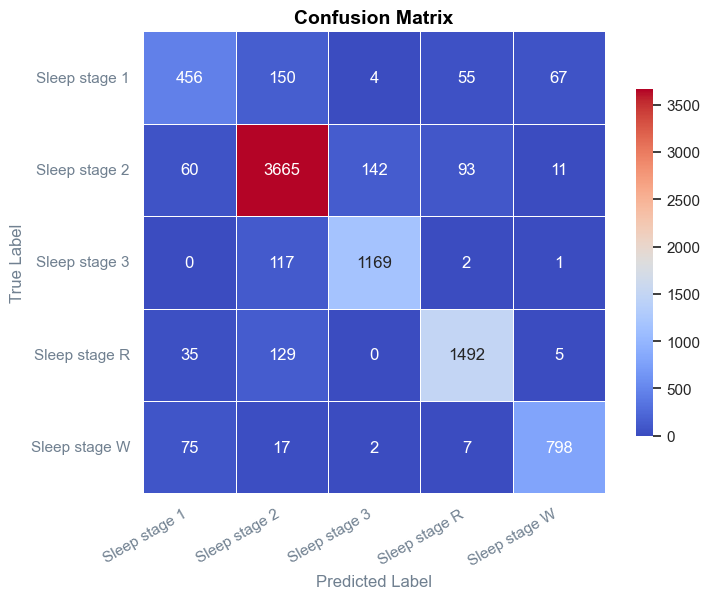

In [66]:
# 3. Print Confusion Matrix
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_test, y_pred_classes)

# Set up the figure
plt.figure(figsize=(8, 6))
sns.set(style="whitegrid")  # Clean background

# Create the heatmap
ax = sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm", linewidths=0.5, 
                 xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_,
                 cbar_kws={"shrink": 0.75}, square=True)  # Reduce color bar size, make it square

# Formatting
plt.xlabel("Predicted Label", fontsize=12, color='slategray')
plt.ylabel("True Label", fontsize=12, color='slategray')
plt.title("Confusion Matrix", fontsize=14, fontweight='bold', color='black')

# Rotate x-axis labels for clarity
plt.xticks(rotation=30, ha="right", color='slategray')
plt.yticks(color='slategray')

# Show the plot
plt.show()


c:\Users\marie\Downloads\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning:

unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.



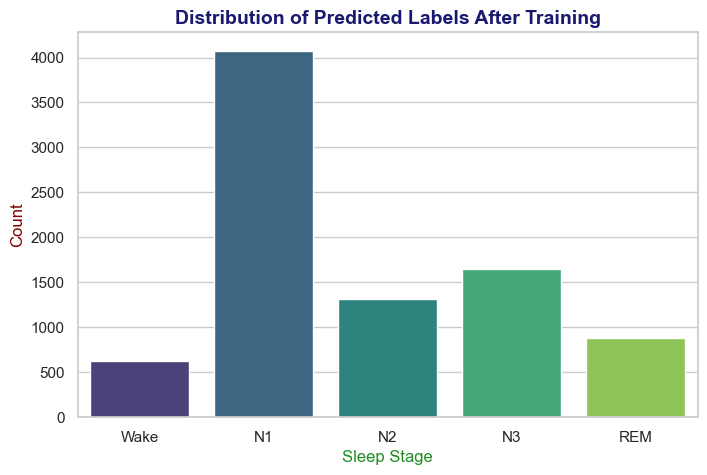

In [64]:
# Define the mapping of numerical labels to sleep stage names
sleep_stage_labels = {
    0: 'Wake',
    1: 'N1',
    2: 'N2',
    3: 'N3',
    4: 'REM'
}

# Count predicted labels
label_counts = pd.Series(y_pred_classes).value_counts().sort_index()

# Convert numeric labels to their corresponding sleep stage names
label_names = [sleep_stage_labels[label] for label in label_counts.index]

# Plot bar chart with sleep stage labels
plt.figure(figsize=(8, 5))
sns.barplot(x=label_names, y=label_counts.values, palette="viridis")

# Update axis labels
plt.xlabel("Sleep Stage", fontsize=12, color='forestgreen')
plt.ylabel("Count", fontsize=12, color='maroon')
plt.title("Distribution of Predicted Labels After Training", fontsize=14, fontweight='bold', color='midnightblue')

plt.show()


In [67]:
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 262, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 262, 256)  │    133,120 │ input_layer[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 262, 256)  │      1,024 │ bidirectional[0]… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 262, 256)  │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 262, 256)  │    394,240 │ dropout[0][0]     │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 262, 256)  │      1,024 │ bidirectional_1[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 262, 256)  │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 262, 256)  │          0 │ dropout_1[0][0],  │
│                     │                   │            │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer     │ (None, 256)       │        256 │ add[0][0]         │
│ (AttentionLayer)    │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ attention_layer[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 512)       │    131,584 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512)       │      2,048 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 512)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │    131,328 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_1[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 256)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 256)       │     65,792 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 256)       │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 256)       │          0 │ dropout_4[0][0],  │
│                     │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 2,585,105 (9.86 MB)

 Trainable params: 860,677 (3.28 MB)

 Non-trainable params: 3,072 (12.00 KB)

 Optimizer params: 1,721,356 (6.57 MB)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.
268/268 ━━━━━━━━━━━━━━━━━━━━ 41s 152ms/step


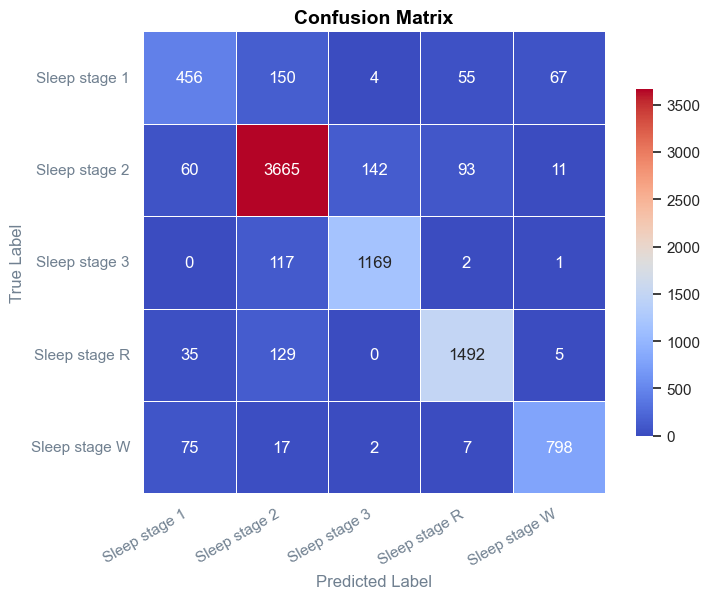

In [ ]:


# 1. Print model architecture
tf.keras.utils.plot_model(model, to_file="model_architecture.png", show_shapes=True, show_layer_names=True)

# 3. Print Confusion Matrix
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_test, y_pred_classes)

# Set up the figure
plt.figure(figsize=(8, 6))
sns.set(style="whitegrid")  # Clean background

# Create the heatmap
ax = sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm", linewidths=0.5, 
                 xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_,
                 cbar_kws={"shrink": 0.75}, square=True)  # Reduce color bar size, make it square

# Formatting
plt.xlabel("Predicted Label", fontsize=12, color='slategray')
plt.ylabel("True Label", fontsize=12, color='slategray')
plt.title("Confusion Matrix", fontsize=14, fontweight='bold', color='black')

# Rotate x-axis labels for clarity
plt.xticks(rotation=30, ha="right", color='slategray')
plt.yticks(color='slategray')

# Show the plot
plt.show()


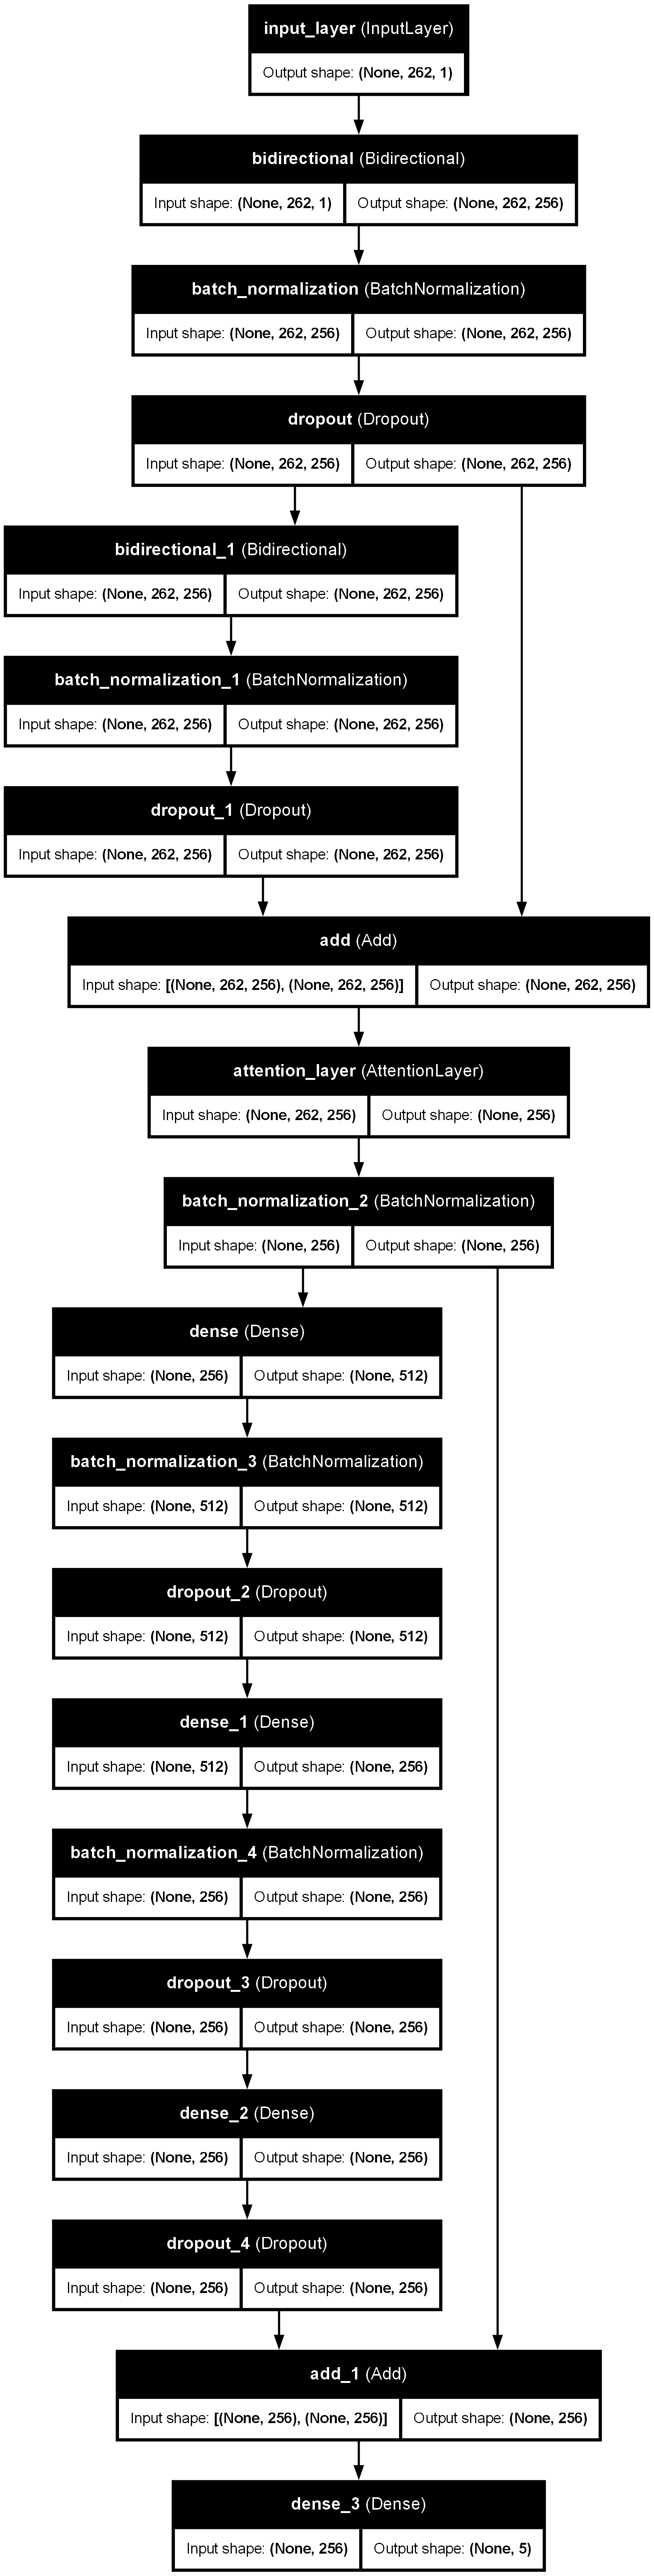

In [78]:
# Save model architecture as an image
tf.keras.utils.plot_model(model, to_file="model_architecture.png", show_shapes=True, show_layer_names=True)


In [77]:
import os
os.environ["PATH"] += os.pathsep + r"C:\Users\marie\Downloads\windows_10_cmake_Release_Graphviz-12.2.1-win64\Graphviz-12.2.1-win64\bin"


You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


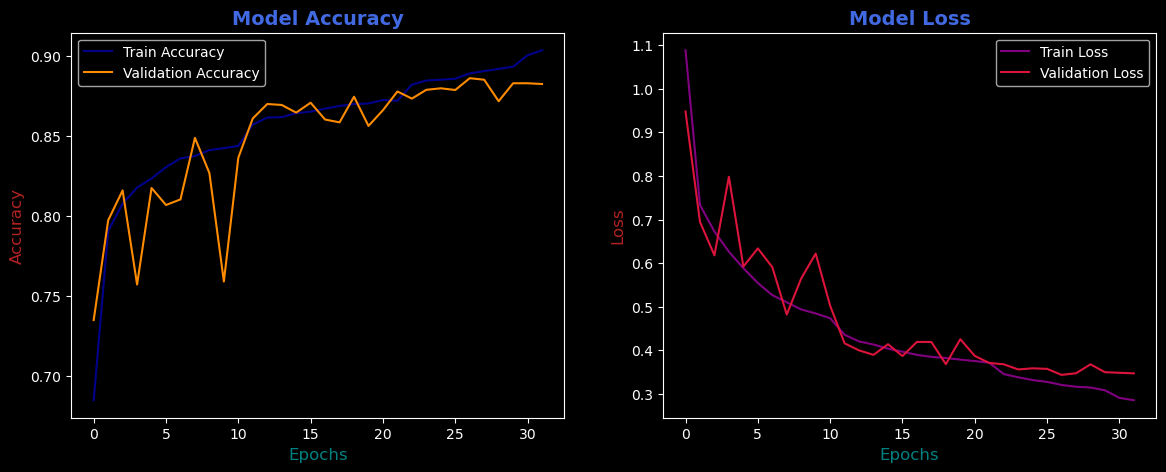

268/268 ━━━━━━━━━━━━━━━━━━━━ 47s 176ms/step


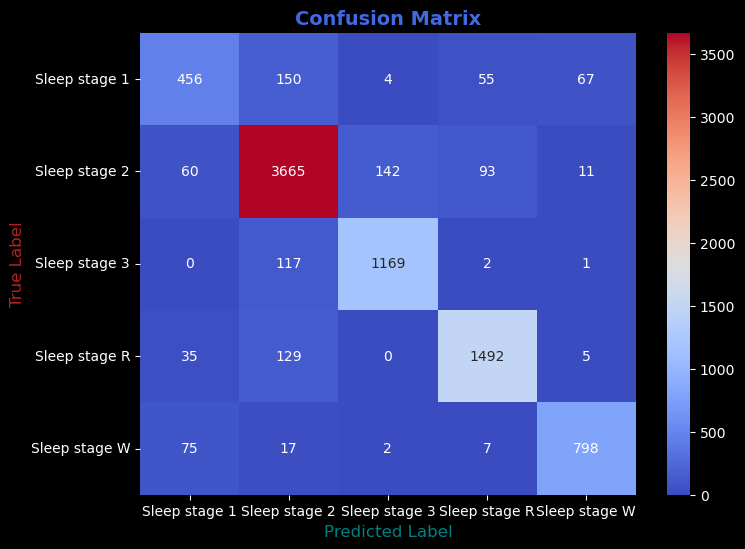

Classification Report:
                precision    recall  f1-score   support

Sleep stage 1       0.73      0.62      0.67       732
Sleep stage 2       0.90      0.92      0.91      3971
Sleep stage 3       0.89      0.91      0.90      1289
Sleep stage R       0.90      0.90      0.90      1661
Sleep stage W       0.90      0.89      0.90       899

     accuracy                           0.89      8552
    macro avg       0.86      0.85      0.86      8552
 weighted avg       0.88      0.89      0.88      8552



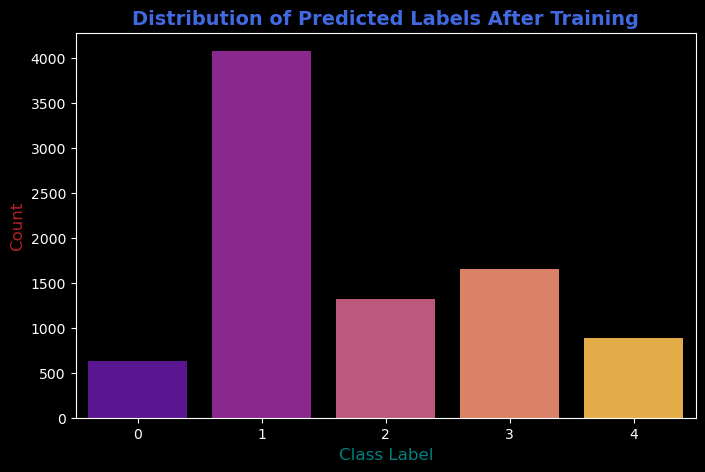

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf

# 1. Print model architecture as an image
tf.keras.utils.plot_model(model, to_file="model_architecture.png", show_shapes=True, show_layer_names=True)

# 2. Plot Accuracy and Loss Graphs
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy plot
axes[0].plot(history.history['accuracy'], label='Train Accuracy', color='darkblue')
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy', color='darkorange')
axes[0].set_title('Model Accuracy', fontsize=14, fontweight='bold', color='royalblue')
axes[0].set_xlabel('Epochs', fontsize=12, color='teal')
axes[0].set_ylabel('Accuracy', fontsize=12, color='firebrick')
axes[0].legend()

# Loss plot
axes[1].plot(history.history['loss'], label='Train Loss', color='purple')
axes[1].plot(history.history['val_loss'], label='Validation Loss', color='crimson')
axes[1].set_title('Model Loss', fontsize=14, fontweight='bold', color='royalblue')
axes[1].set_xlabel('Epochs', fontsize=12, color='teal')
axes[1].set_ylabel('Loss', fontsize=12, color='firebrick')
axes[1].legend()

plt.show()

# 3. Print Confusion Matrix
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Label", fontsize=12, color='teal')
plt.ylabel("True Label", fontsize=12, color='firebrick')
plt.title("Confusion Matrix", fontsize=14, fontweight='bold', color='royalblue')
plt.show()

# 4. Print Classification Report
report = classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_)
print("Classification Report:\n", report)

# 5. Distribution of Labels After Training
label_counts = pd.Series(y_pred_classes).value_counts().sort_index()
plt.figure(figsize=(8, 5))
sns.barplot(x=label_counts.index, y=label_counts.values, palette="plasma")
plt.xlabel("Class Label", fontsize=12, color='teal')
plt.ylabel("Count", fontsize=12, color='firebrick')
plt.title("Distribution of Predicted Labels After Training", fontsize=14, fontweight='bold', color='royalblue')
plt.show()
